In [116]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/leonidasf300/dl22_2/main/content/init.py
import init; init.init(force_download=False); 


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import pathlib
import joblib

pd.options.mode.chained_assignment = None  # default='warn'


In [118]:
os.listdir('local/data')

['GEFCom2013-2017.xlsx',
 'test.txt',
 'test2.txt',
 'data0_zone1.csv',
 'scaler.joblib']

In [119]:
os.listdir('local/lib')

['__pycache__', 'DataPreparationRNN.py']

In [120]:
df0 = pd.read_csv('local/data/data0_zone1.csv',sep=",",parse_dates=[0])
df0 = df0.rename(columns={"Unnamed: 0": "datetime"})
df0.set_index(["datetime"], inplace=True, drop=True, )
df0

,Dem,T_DryBulb,T_DewPnt,fest,dlf,dfnl,D_cf,med,des,der,...,s,v,w,d_cf,j_cf,l_cf,m_cf,s_cf,v_cf,w_cf
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.555952,17,6,1,0,1,NaN,0.466188,0.037952,NaN,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00,0.532068,19,6,1,0,1,NaN,0.444504,0.038645,NaN,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00,0.514954,20,7,1,0,1,NaN,0.431254,0.040305,NaN,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00,0.506522,21,7,1,0,1,NaN,0.426227,0.042465,NaN,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 04:00:00,0.507768,22,6,1,0,1,NaN,0.430506,0.047256,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-19 19:00:00,0.805296,79,61,0,0,0,NaN,0.621521,0.052476,NaN,...,0,1,0,0,0,0,0,0,0,0
2016-08-19 20:00:00,0.790697,76,63,0,0,0,NaN,0.604878,0.044765,NaN,...,0,1,0,0,0,0,0,0,0,0
2016-08-19 21:00:00,0.745117,75,60,0,0,0,NaN,0.573959,0.043009,NaN,...,0,1,0,0,0,0,0,0,0,0


Text(0.5, 0, 'Date')

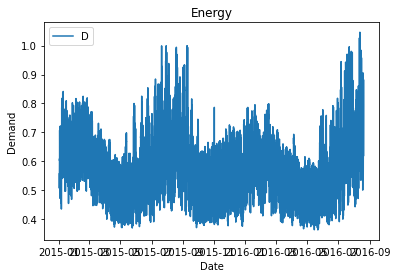

In [121]:
plt.plot(df0.index,df0.Dem)
plt.legend('Demand')
plt.title('Energy')
plt.ylabel('Demand')
plt.xlabel('Date')

In [122]:

FORECAST_DATE_INIT = datetime.datetime(2015,1,1)
TRAINING_DATE_END = FORECAST_DATE_INIT + datetime.timedelta(days=565+31-15)
HNTE = 22*24
NDHT = 15*24
zona1 = df0.copy()

zona1 = zona1.rename_axis('fecha').reset_index() # Se resetea el indice para convertir a diccionario mas facil

colum=zona1.columns[1:]
df_data= zona1.iloc[HNTE:].reset_index(drop=True)
df_data_e = df_data.loc[:len(df_data)-NDHT-1] #El menos 1 es debido a que comienza en cero
df_data_p = df_data.loc[len(df_data)-NDHT:]



In [123]:
## Crear diccionarios para el modelo ##
meteo = ['T_DryBulb','T_DewPnt']
tiempo = []
#resagos = [1,2,3,4,5,24,48,72,96,120,144,166,167,168,169,170]
resagos = [1,2,3,4,5,6,7,8,9,10,168,170,171,172,173,336,338,339,340,341,504,506,507,508,509]
#resagos = [2,3]
horas = []
dias = []
dias_semana = ['m','w','j','v','s','d','dlf','dfnl']
dias_semana_cf = ['l_cf', 'm_cf', 'w_cf', 'j_cf', 'v_cf', 's_cf', 'd_cf']
exponentes = [1,2,3] # exponenetes a los que se elevaran las variables meteorologicas en el modelo

In [124]:
#se crean los dataframe con la informacion de entrenamiento y testeo
X_train = df_data_e[['d', 'j', 'm', 's', 'v', 'w', 'dlf',
                     'dfnl', 'd_cf', 'j_cf', 'l_cf', 'm_cf',
                     's_cf', 'v_cf', 'w_cf', 'T_DryBulb', 'T_DewPnt']]

X_test = df_data_p[['d', 'j', 'm', 's', 'v', 'w', 'dlf',
                     'dfnl', 'd_cf', 'j_cf', 'l_cf', 'm_cf',
                     's_cf', 'v_cf', 'w_cf', 'T_DryBulb', 'T_DewPnt']]

for i in df_data_e.index:
  for j in resagos:
    X_train.loc[i,'r_'+str(j)] = zona1.iloc[i+HNTE-j,1]

for i in df_data_p.index:
  for j in resagos:
    X_test.loc[i,'r_'+str(j)] = zona1.iloc[i+HNTE-j,1]

for i in exponentes[1:]:
  X_train['T_Dry_'+str(i)] = df_data_e['T_DryBulb']**i
  X_train['T_Dew_'+str(i)] = df_data_e['T_DewPnt']**i

for i in exponentes[1:]:
  X_test['T_Dry_'+str(i)] = df_data_p['T_DryBulb']**i
  X_test['T_Dew_'+str(i)] = df_data_p['T_DewPnt']**i

X_train.insert(0, 'inter', 1)
X_test.insert(0, 'inter', 1)

y_train = df_data_e['Dem']
y_test = df_data_p['Dem']

In [125]:
y_test2=y_test.copy()

In [126]:
X_train.shape

(13440, 47)

In [127]:
with open('local/data/scaler.joblib', "rb") as scaler_file:
    scaler = joblib.load(scaler_file)

In [128]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

lasso_reg = LassoCV(cv=10, random_state=20221112, alphas=np.arange(0.5,10,0.5))
lasso_reg.fit(X=X_train.values, y=y_train.values)

pron_realista_lasso_reg = {} # pronotico realista
pron_realista_lasso = {} # pronotico realista
demanda=df_data_e['Dem'].to_dict()
    # for t,i in enumerate(range(len(demanda),len(demanda)+NDHT)):
X_test_c = X_test.copy()
for i in X_test_c.index:
    d=lasso_reg.predict(X_test_c.loc[i].to_numpy().reshape(1,-1))[0]
    #print(d,i)
    pron_realista_lasso_reg[i]=d
    for r in resagos:
        if i+r > len(demanda)+NDHT:
            break
        else:  
            X_test_c.loc[i+r,'r_'+str(r)]=d # pone el nuevo resultado de la demanda pronosticada en el resago que le corresponde para cada hora y poder hacer el pronostico con este.




In [129]:
#https://www.programiz.com/python-programming/nested-dictionary
DictModels={}
DictDefault={'name':'NA',
             'MAPE':99,
             'RMSE':999999,
             'y_predict':[0,0,0]}


DictModels[1]=DictDefault

In [130]:

y_test_inv = scaler.inverse_transform(y_test.values.reshape(-1,1))
y_hat_inv_lasso_reg = scaler.inverse_transform(
    np.array(list(pron_realista_lasso_reg.values())).reshape(-1,1)
)
MAPE_lasso_reg = mean_absolute_percentage_error(y_true=y_test_inv, y_pred=y_hat_inv_lasso_reg, )
RMSE_lasso_reg= mean_squared_error(y_true=y_test_inv, y_pred=y_hat_inv_lasso_reg, squared=False)
print(f"MAPE LassoCV with alpha {lasso_reg.alpha_}: {MAPE_lasso_reg:.2%}")
print(f"RMSE Lasso with alpha {lasso_reg.alpha_}: {RMSE_lasso_reg:.2f}")

MAPE LassoCV with alpha 0.5: 9.20%
RMSE Lasso with alpha 0.5: 1752.78


In [131]:
DictModels[1]['name']='Lasso'
DictModels[1]['MAPE']=MAPE_lasso_reg
DictModels[1]['RMSE']=RMSE_lasso_reg
DictModels[1]['y_predict']=y_hat_inv_lasso_reg

In [132]:
import plotly.graph_objects as go 

fig = go.Figure()
fig.add_traces(
    [
        go.Scatter(x=df_data_p["fecha"].values, y=scaler.inverse_transform(y_test.values.reshape(-1,1)).reshape(-1), name='Real values', customdata=X_test["r_1"].values, hovertemplate='<b>Real Data</b><br>Date: %{x}<br>Scaled Demand: %{y}<br>Resago 1: %{customdata}'),
        go.Scatter(x=df_data_p["fecha"].values, y=scaler.inverse_transform(np.array(list(pron_realista_lasso_reg.values())).reshape(-1,1)).reshape(-1), name="LassoCV",),

        
    ]
)
fig.update_layout(
    {
        "xaxis_title": "Fecha",
        "yaxis_title": "Scaled demand"
    }
)
# fig.write_html("results.html")
fig.show()

In [133]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, RepeatVector, TimeDistributed, LSTM
from tensorflow import keras
from local.lib import DataPreparationRNN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#-----
from local.lib.DataPreparationRNN import split_sequence
from sklearn.preprocessing import MinMaxScaler


In [134]:
def convert(df_in):
  l_col=list()
  for i in df_in.columns:
    if i != 'Dem':
      l_col.append(i)

  df=df_in.drop(columns=l_col, axis=1)
  dataset = df.values
  dataset = dataset.astype('float32')
  return dataset



In [135]:
df=convert(df_data_e)
df

array([[0.5243001 ],
       [0.5092631 ],
       [0.5041123 ],
       ...,
       [0.71131396],
       [0.6441845 ],
       [0.58021486]], dtype=float32)

In [136]:
look_back=2
# split into train and test sets
#train_size = int(len(dataset) * 0.67)
#test_size = len(dataset) - train_size
#train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

trainN = convert(df_data_e)
testN = convert(df_data_p)

# normalize the dataset
#scaler = MinMaxScaler(feature_range=(0, 1))
#trainN = scaler.fit_transform(train)
#testN = scaler.transform(test)

#tensor formating

X_train, y_train = split_sequence(trainN, look_back)
X_test, y_test = split_sequence(testN, look_back)
print('Train',X_train[:10])
print('Test',y_train[:10])

Train [[[0.5243001 ]
  [0.5092631 ]]

 [[0.5092631 ]
  [0.5041123 ]]

 [[0.5041123 ]
  [0.50735235]]

 [[0.50735235]
  [0.5245493 ]]

 [[0.5245493 ]
  [0.5719864 ]]

 [[0.5719864 ]
  [0.6543989 ]]

 [[0.6543989 ]
  [0.69660217]]

 [[0.69660217]
  [0.69531447]]

 [[0.69531447]
  [0.6858852 ]]

 [[0.6858852 ]
  [0.677079  ]]]
Test [[0.5041123 ]
 [0.50735235]
 [0.5245493 ]
 [0.5719864 ]
 [0.6543989 ]
 [0.69660217]
 [0.69531447]
 [0.6858852 ]
 [0.677079  ]
 [0.666819  ]]


In [137]:

model1 = Sequential()
model1.add(Dense(5,activation = 'relu',input_dim=look_back))
model1.add(Dense(1))
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 5)                 15        
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [138]:
model1.compile(optimizer='adam',loss='mse')
model1.fit(X_train.reshape(X_train.shape[0],look_back),y_train.flatten(),epochs=200, verbose=0)
trainPredict, testPredict = DataPreparationRNN.EstimaRMSE(model1,X_train,X_test,y_train,y_test,scaler,look_back)
#DataPreparationRNN.PintaResultado(trainN,trainPredict,testPredict,look_back)

12/12 [==============================] - 0s 2ms/step
Train Score: 389.89 RMSE
Test Score: 380.54 RMSE
Train Score: 1.90 MAPE
Test Score: 1.47 MAPE


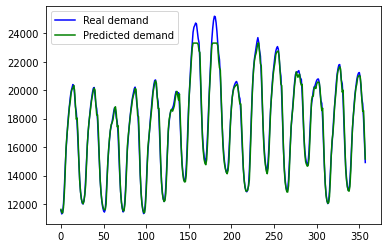

In [139]:
plt.plot(scaler.inverse_transform(y_test),'b',label='Real demand')
plt.plot(testPredict,'g',label='Predicted demand')
plt.legend()
plt.show()